**<h1>AHJ Database: California Built Environment Personnel Mapping 2025**
#### Analysis 2 =  Analysis 1 (AHJ Boundaries & Contacts) + Geomap
<i>Any question regarding the notebook, please contact Robert Ford<br>
    Last Updated: 06/13/2025</i>
* AHJ Data: Various Position searches using Transparent America
* Geo Data: Various open source databases including state and federal - ranging from census, ArcGIS, and other open sources
* Started development on 06/13/2025
* Finished Iteration 1 on -06//2025-

In [18]:
# Import and load libs and packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

In [19]:
# Read Files and load data
ca_personnel = pd.read_excel("Composite Position Search Results.xlsx", sheet_name="F_Composite Position Search")
ca_geo_df = gpd.read_file("City_and_County_Boundary_Line_Changes_5487330134999085531.geojson")

In [ ]:
# Visual Checks of headers for personnel data and geodata 
#print(ca_geo_df.head())


In [20]:
# Helper function to classify agency, city, and or county
def classify_agency(agency):
    agency_lower = str(agency).lower()
    if 'county' in agency_lower:
        return 'county'
    else:
        return 'city'

ca_personnel['type'] = ca_personnel['Agency'].apply(classify_agency)

# Clean Agency name for easier matching
def clean_name(name):
    name = str(name).lower()
    name = re.sub(r'county|department|dept|agency|office', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().title()

ca_personnel['clean_name'] = ca_personnel['Agency'].apply(clean_name)

In [21]:
# Count employees per agency
agg_counts = (
    ca_personnel.groupby(['clean_name', 'type'])
    .size()
    .reset_index(name='personnel_count')
)

In [22]:
# Load geospatial data
geo_df = gpd.read_file("City_and_County_Boundary_Line_Changes_5487330134999085531.geojson")

# Separate city and county geometries
geo_df_city = geo_df.copy()
geo_df_county = geo_df.copy()

# Clean city and county names for joining
geo_df_city['clean_name'] = geo_df_city['CITY'].apply(lambda x: clean_name(str(x)))
geo_df_city['type'] = 'city'

geo_df_county['clean_name'] = geo_df_county['COUNTY'].apply(lambda x: clean_name(str(x)))
geo_df_county['type'] = 'county'

# Merge personnel counts into city and county geodata
geo_df_city = geo_df_city.merge(
    agg_counts[agg_counts['type'] == 'city'],
    on=['clean_name', 'type'],
    how='left'
)

geo_df_county = geo_df_county.merge(
    agg_counts[agg_counts['type'] == 'county'],
    on=['clean_name', 'type'],
    how='left'
)

geo_df_city['personnel_count'] = geo_df_city['personnel_count'].fillna(0)
geo_df_county['personnel_count'] = geo_df_county['personnel_count'].fillna(0)



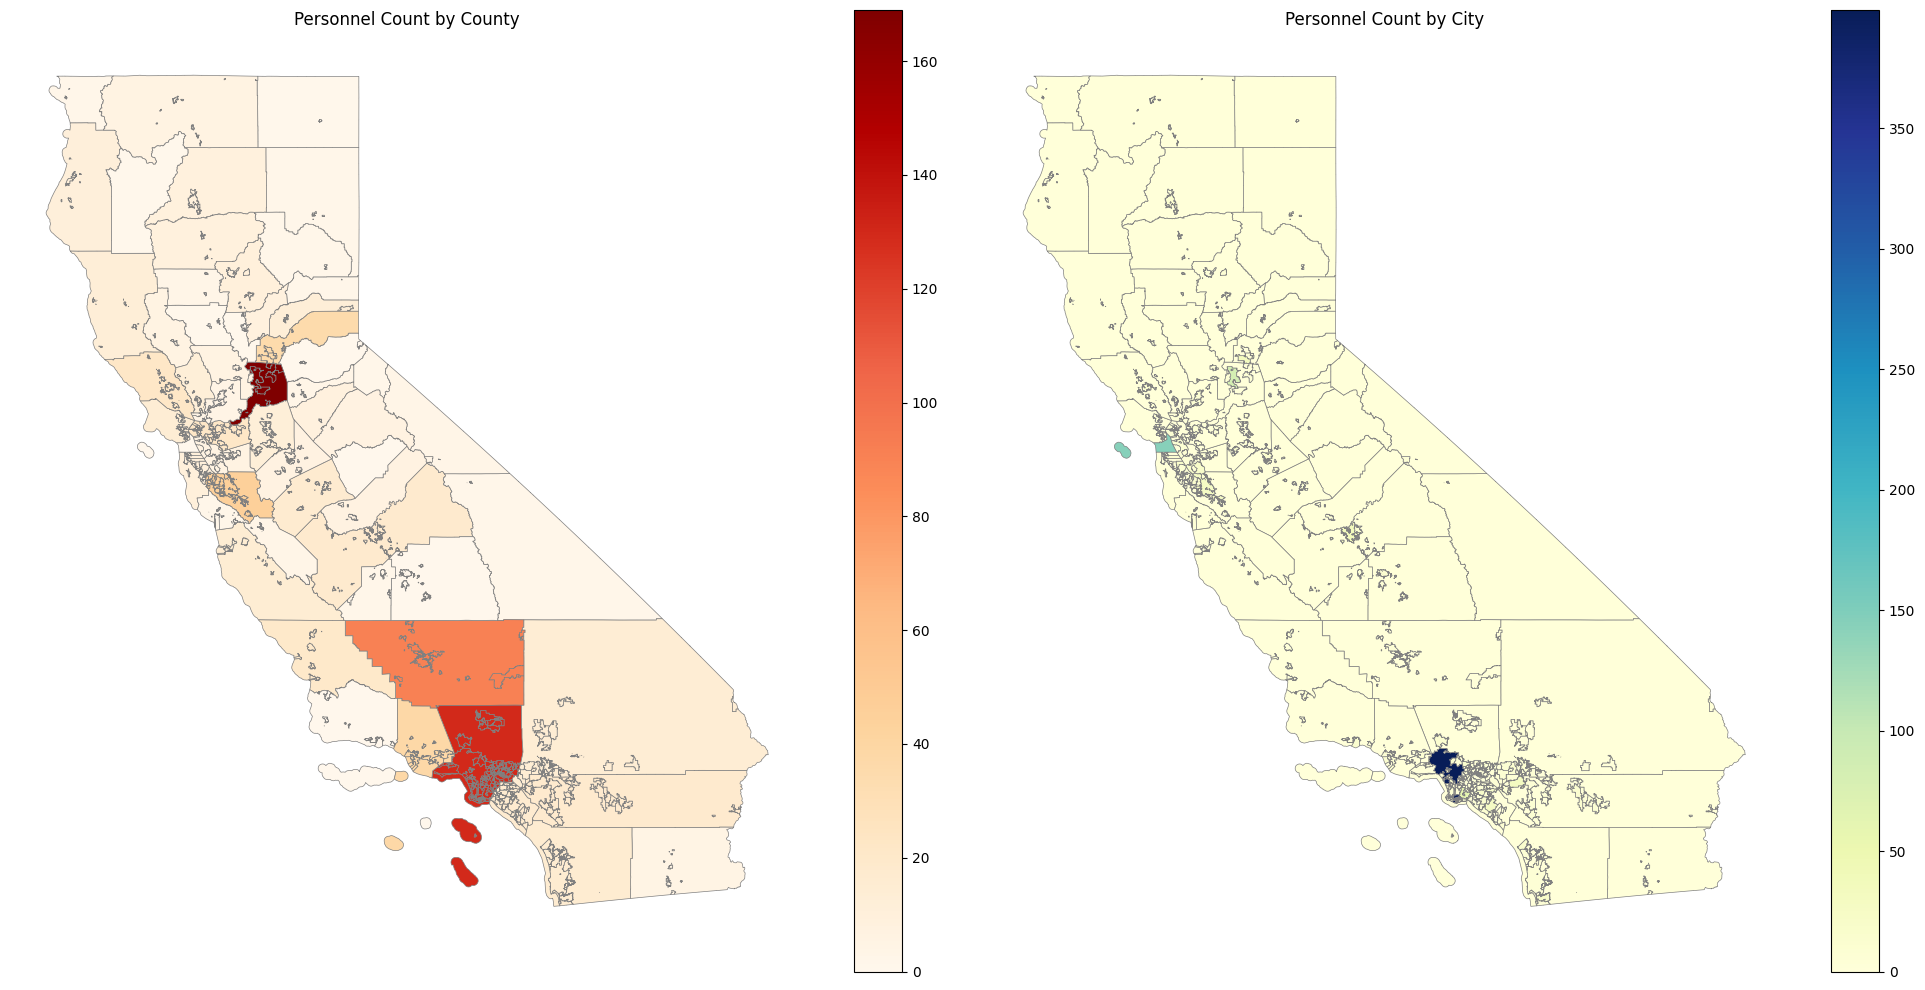

In [23]:
# Plot side-by-side maps
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# County Map
geo_df_county.plot(
    column='personnel_count',
    cmap='OrRd',
    linewidth=0.5,
    ax=axs[0],
    edgecolor='gray',
    legend=True
)
axs[0].set_title('Personnel Count by County')
axs[0].axis('off')

# City Map
geo_df_city.plot(
    column='personnel_count',
    cmap='YlGnBu',
    linewidth=0.5,
    ax=axs[1],
    edgecolor='gray',
    legend=True
)
axs[1].set_title('Personnel Count by City')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Ensure 'Total Pay' is numeric
ca_personnel['Total Pay'] = pd.to_numeric(ca_personnel['Total Pay'], errors='coerce').fillna(0)

# Aggregate personnel count and total pay
agg_data = (
    ca_personnel
    .groupby(['clean_name', 'type'])
    .agg(personnel_count=('Employee Name', 'count'),
         total_pay=('Total Pay', 'sum'))
    .reset_index()
)

In [25]:
# Load combined GeoJSON with CITY and COUNTY columns
geo_df = gpd.read_file("City_and_County_Boundary_Line_Changes_5487330134999085531.geojson")

# Split into city and county GeoDataFrames
geo_city = geo_df.copy()
geo_county = geo_df.copy()

geo_city['clean_name'] = geo_city['CITY'].apply(lambda x: clean_name(str(x)))
geo_city['type'] = 'city'

geo_county['clean_name'] = geo_county['COUNTY'].apply(lambda x: clean_name(str(x)))
geo_county['type'] = 'county'

# Merge personnel data
geo_city = geo_city.merge(
    agg_data[agg_data['type'] == 'city'],
    on=['clean_name', 'type'],
    how='left'
)

geo_county = geo_county.merge(
    agg_data[agg_data['type'] == 'county'],
    on=['clean_name', 'type'],
    how='left'
)

# Fill missing values
geo_city[['personnel_count', 'total_pay']] = geo_city[['personnel_count', 'total_pay']].fillna(0)
geo_county[['personnel_count', 'total_pay']] = geo_county[['personnel_count', 'total_pay']].fillna(0)


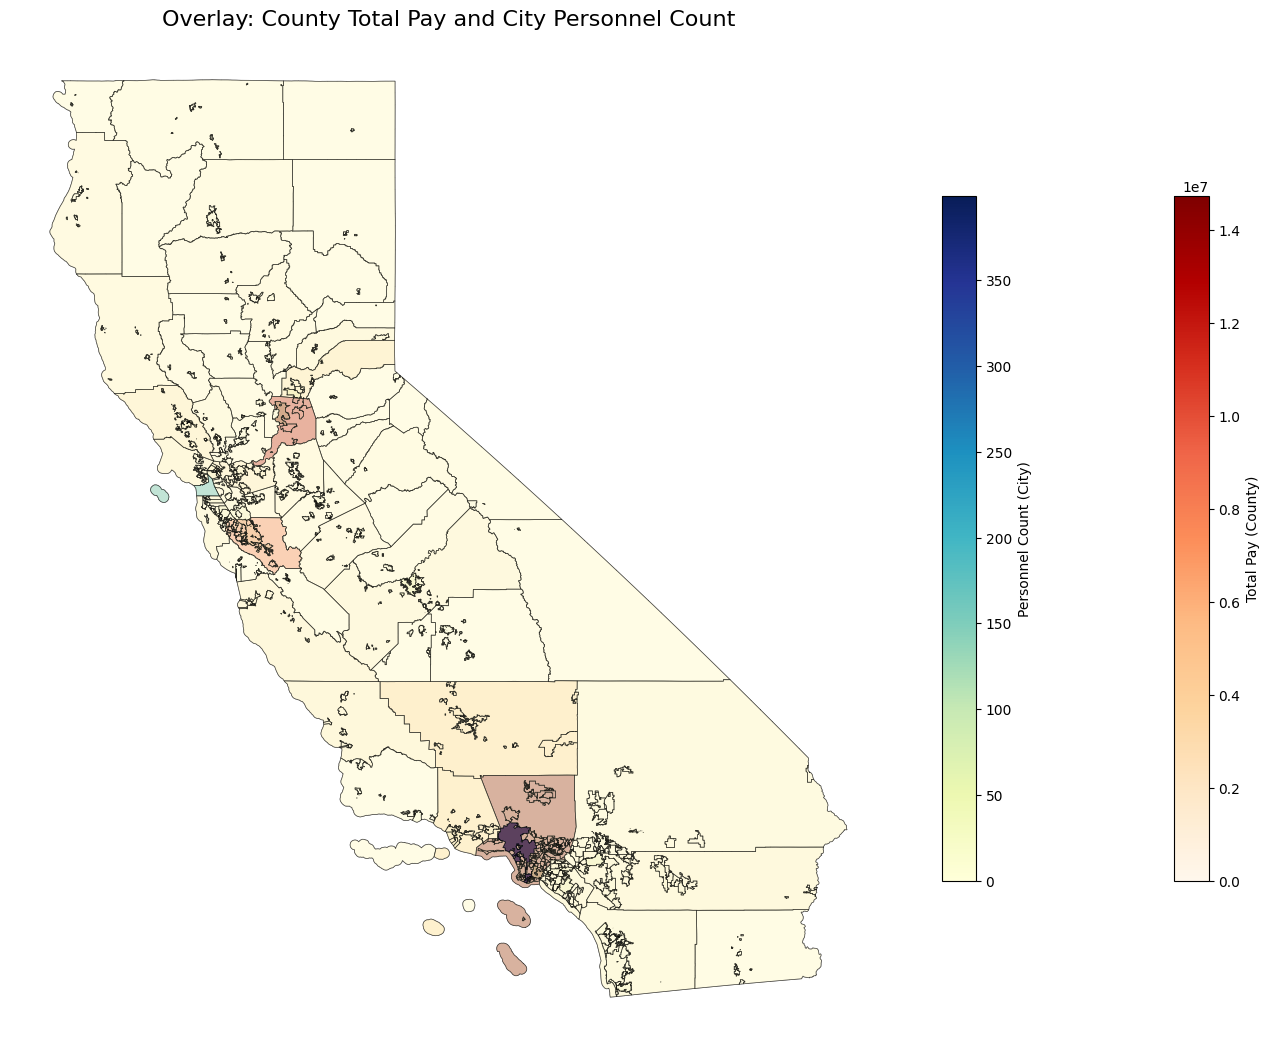

In [ ]:
# Plot overlay map
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Plot county layer (total pay)
geo_county.plot(
    column='total_pay',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Total Pay (County)", 'shrink': 0.5},
    ax=ax,
    alpha=0.6
)

# Plot city layer (personnel count)
geo_city.plot(
    column='personnel_count',
    cmap='YlGnBu',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Personnel Count (City)", 'shrink': 0.5},
    ax=ax,
    alpha=0.5
)

ax.set_title("Overlay: County Total Pay and City Personnel Count", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()